In [1]:
import json
import os
from datetime import datetime
from typing import List, Dict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler


In [2]:
DATA_FILENAME = '/Users/cesar/workspaces/merclib/data/MLA_100k_checked_v3.jsonlines'


In [3]:
######################################################
# Build dataset from raw format
######################################################
def build_dataset(filename: str = DATA_FILENAME) -> pd.DataFrame:
    data = [json.loads(x) for x in open(filename)]
    target = lambda x: x.get("condition")
    N = -10000
    X_train = data[:N]
    X_test = data[N:]
    y_train = [target(x) for x in X_train]
    y_test = [target(x) for x in X_test]
    for x in X_test:
        del x["condition"]
    return X_train, y_train, X_test, y_test

######################################################
# Build cleaned dataset
######################################################
def build_dataset_df(dataset: List[dict]) -> pd.DataFrame:
    print("Start cleaning dataset...")
    dataset_df = pd.json_normalize(dataset)
    columns_to_discard = [
        'differential_pricing', 'subtitle', 'catalog_product_id',
        'shipping.dimensions', 'original_price', 'official_store_id',
        'video_id', 'shipping.free_methods', 'sub_status', 'deal_ids',
        'variations', 'attributes', 'coverage_areas', 'listing_source',
        'international_delivery_mode', 'shipping.methods', 'shipping.tags',
        'seller_address.country.id', 'seller_address.state.id', 'seller_address.city.id',
        'seller_id', 'site_id', 'parent_item_id', 'category_id', 'currency_id',
        'descriptions', 'seller_address.country.name', 'seller_address.state.name',
        'seller_address.city.name'
    ]
    dataset_df.drop(columns_to_discard, axis = 1, inplace = True)

    # Build count for list type fields
    counts_df = build_count_fields_from_list(dataset_df)
    dataset_df = pd.concat([dataset_df, counts_df], axis = 1)

    # Handle datetime fields
    datetime_df = transform_datetime_fields(dataset_df)
    dataset_df = pd.concat([dataset_df, datetime_df], axis = 1)

    # Subset columns for post processing
    columns_to_keep = [
        'price',
        'listing_type_id',
        'buying_mode',
        'tags',
        'accepts_mercadopago',
        'automatic_relist',
        'status',
        'initial_quantity',
        'sold_quantity',
        'available_quantity',
        'shipping.local_pick_up',
        'shipping.free_shipping',
        'shipping.mode',
        'non_mercado_pago_payment_methods',
        'non_mercado_pago_payment_methods_count',
        'pictures_count',
        'age_days',
        'duration_days',
    ]
    dataset_df = dataset_df[columns_to_keep]

    # Replace nan with zeros for count fields
    dataset_df['non_mercado_pago_payment_methods_count'].fillna(0, inplace = True)
    dataset_df['pictures_count'].fillna(0, inplace = True)

    print("Finished cleaning dataset...")
    print("Dataset shape: ", dataset_df.shape)

    return dataset_df


def build_count_fields_from_list(dataset_df: pd.DataFrame) -> pd.DataFrame:
    list_type_cols = [
        'non_mercado_pago_payment_methods', 'pictures'
    ]
    # Build the count fields
    list_type_cols_data = {}
    for col in list_type_cols:
        list_type_cols_data[col] = dataset_df[col].apply(
            lambda x: np.nan if len(x) == 0 else len(x)
        )

    df_list_cols = pd.DataFrame(
        data = list_type_cols_data
    )

    # Rename columns with count suffix
    df_list_cols.rename(
        columns = {
            'non_mercado_pago_payment_methods': 'non_mercado_pago_payment_methods_count',
            'pictures': 'pictures_count',
        },
        inplace = True
    )

    return df_list_cols

def transform_datetime_fields(dataset_df: pd.DataFrame) -> pd.DataFrame:
    df = dataset_df.copy()
    # Transform stop_time and start_time to datetime format
    df['start_time_dt'] = df['start_time'].apply(lambda x: datetime.fromtimestamp(x / 1000))
    df['stop_time_dt'] = df['stop_time'].apply(lambda x: datetime.fromtimestamp(x / 1000))

    # Transform date_created and last_updated to datetime format
    df['date_created_dt'] = pd.to_datetime(df['date_created'])
    df['last_updated_dt'] = pd.to_datetime(df['last_updated'])

    df['age_days'] = (df['last_updated_dt'] - df['date_created_dt']).apply(
        lambda x: x.total_seconds() / (60 * 60 * 24)
    )
    df['duration_days'] = (df['stop_time_dt'] - df['start_time_dt']).apply(
        lambda x: x.total_seconds() / (60 * 60 * 24)
    )

    return df[['age_days', 'duration_days']]

######################################################
# Build processed dataset
######################################################
def build_processed_dataset(dataset_df: pd.DataFrame) -> Dict[str, any]:
    """
    Takes a cleaned dataset in pandas dataframe format and returns a dictionary
    with processed data, sacalers and encoders.
    """
    print("Start processing dataset...")
    processed_dataset_df = dataset_df.copy()

    print("One hot encoding categorical variables...")
    # One hot encode categorical variables
    # Single value columns
    ohe_listing_type = OneHotEncoder()
    ohe_buying_mode = OneHotEncoder()
    ohe_status = OneHotEncoder()
    ohe_shipping_mode = OneHotEncoder()
    processed_dataset_df = one_hot_encode(processed_dataset_df, 'listing_type_id', ohe_listing_type, True)
    processed_dataset_df = one_hot_encode(processed_dataset_df, 'buying_mode', ohe_buying_mode, True)
    processed_dataset_df = one_hot_encode(processed_dataset_df, 'status', ohe_status, True)
    processed_dataset_df = one_hot_encode(processed_dataset_df, 'shipping.mode', ohe_shipping_mode, True)
    # Multi value columns
    # 1. Process tags
    processed_dataset_df = one_hot_encode_tags(processed_dataset_df)
    # 2. Process payment methods
    processed_dataset_df = one_hot_encode_payment_methods(processed_dataset_df)

    print("Finished one hot encoding categorical variables...")

    print("Handling boolean variables...")
    # Build boolean variables
    processed_dataset_df['accepts_mercadopago'] = processed_dataset_df['accepts_mercadopago'].astype(int)
    processed_dataset_df['automatic_relist'] = processed_dataset_df['automatic_relist'].astype(int)
    processed_dataset_df['shipping.local_pick_up'] = processed_dataset_df['shipping.local_pick_up'].astype(int)
    processed_dataset_df['shipping.free_shipping'] = processed_dataset_df['shipping.free_shipping'].astype(int)
    print("Finished handling boolean variables...")

    # print("Scaling variables...")
    # # Build scaler
    # scaler = StandardScaler()
    # vars_scaled = scaler.fit_transform(processed_dataset_df)
    # processed_dataset_df[vars_to_scale] = vars_scaled
    # print("Finished scaling variables...")

    # Build response
    response = {
        'dataset': processed_dataset_df,
        # 'scaler': scaler,
        'ohe_listing_type': ohe_listing_type,
        'ohe_buying_mode': ohe_buying_mode,
        'ohe_status': ohe_status,
        'ohe_shipping_mode': ohe_shipping_mode
    }

    print("Finished processing dataset...")
    print("Processed dataset shape: ", processed_dataset_df.shape)

    return response

def build_processed_test_dataset(
    dataset_df: pd.DataFrame,
    # scaler: StandardScaler,
    encoders: Dict[str, OneHotEncoder]
) -> pd.DataFrame:
    """
    Takes a cleaned test dataset in pandas dataframe format with a scaler and
    encoders and returns a dictionary with processed data.
    """
    print("Start processing dataset...")
    processed_dataset_df = dataset_df.copy()

    # print("Scaling numerical variables...")
    # # Build scaler
    # vars_to_scale = [
    #     'price', 'initial_quantity', 'sold_quantity', 'available_quantity',
    #     'non_mercado_pago_payment_methods_count', 'pictures_count',
    #     'age_days', 'duration_days'
    # ]
    # vars_scaled = scaler.transform(processed_dataset_df[vars_to_scale])
    # processed_dataset_df[vars_to_scale] = vars_scaled
    # print("Finished scaling numerical variables...")

    print("One hot encoding categorical variables...")
    # One hot encode categorical variables
    # Single value columns
    ohe_listing_type = encoders['ohe_listing_type']
    ohe_buying_mode = encoders['ohe_buying_mode']
    ohe_status = encoders['ohe_status']
    ohe_shipping_mode = encoders['ohe_shipping_mode']
    processed_dataset_df = one_hot_encode(processed_dataset_df, 'listing_type_id', ohe_listing_type, True, False)
    processed_dataset_df = one_hot_encode(processed_dataset_df, 'buying_mode', ohe_buying_mode, True, False)
    processed_dataset_df = one_hot_encode(processed_dataset_df, 'status', ohe_status, True, False)
    processed_dataset_df = one_hot_encode(processed_dataset_df, 'shipping.mode', ohe_shipping_mode, True, False)
    # Multi value columns
    # 1. Process tags
    processed_dataset_df = one_hot_encode_tags(processed_dataset_df)
    # 2. Process payment methods
    processed_dataset_df = one_hot_encode_payment_methods(processed_dataset_df)

    print("Finished one hot encoding categorical variables...")

    print("Handling boolean variables...")
    # Build boolean variables
    processed_dataset_df['accepts_mercadopago'] = processed_dataset_df['accepts_mercadopago'].astype(int)
    processed_dataset_df['automatic_relist'] = processed_dataset_df['automatic_relist'].astype(int)
    processed_dataset_df['shipping.local_pick_up'] = processed_dataset_df['shipping.local_pick_up'].astype(int)
    processed_dataset_df['shipping.free_shipping'] = processed_dataset_df['shipping.free_shipping'].astype(int)
    print("Finished handling boolean variables...")

    print("Finished processing dataset...")
    print("Processed dataset shape: ", processed_dataset_df.shape)

    return processed_dataset_df

######################################################
# Helper functions
######################################################
def one_hot_encode(
    df: pd.DataFrame, column: str, ohe: OneHotEncoder,
    drop: bool = False, is_fit: bool = True
) -> pd.DataFrame:
    """
    This function takes a dataframe and a column name as input and returns a
    new dataframe with the one hot encoded values of the column.
    """
    # Create a copy of the dataframe to avoid modifying the original dataframe
    df_copy = df.copy()

    # One hot encode the column
    if is_fit:
        encoded_data = ohe.fit_transform(df_copy[[column]]).toarray()
    else:
        encoded_data = ohe.transform(df_copy[[column]]).toarray()

    # Get the names of the new columns
    column_names = ohe.get_feature_names_out([column])

    # Create a new dataframe with the one hot encoded values
    encoded_df = pd.DataFrame(
        encoded_data,
        columns = column_names,
        index = df_copy.index
    )

    # Concatenate the new dataframe with the original one
    df_copy = pd.concat([df_copy, encoded_df], axis = 1)

    # Drop the original column
    if drop: df_copy.drop(column, axis = 1, inplace = True)

    return df_copy

def get_tags_dict(row):
    res = {
        'dragged_bids_and_visits': 0,
        'good_quality_thumbnail': 0,
        'dragged_visits': 0,
        'free_relist': 0,
        'poor_quality_thumbnail': 0
    }

    for val in row:
        res[val] = 1

    return res

def one_hot_encode_tags(df: pd.DataFrame, drop: bool = True):
    """
    Takes a tag column and returns a dataframe with the one hot encoded values of the column.
    """
    # Create a copy of the dataframe to avoid modifying the original dataframe
    df_copy = df.copy()

    # One hot encode the column
    encoded_data = pd.json_normalize(df_copy['tags'].apply(get_tags_dict))

    # Concatenate the new dataframe with the original one
    df_copy = pd.concat([df_copy, encoded_data], axis = 1)

    # Drop the original column
    if drop: df_copy.drop('tags', axis = 1, inplace = True)

    return df_copy

def get_payment_methods(x):
    if len(x) == 0:
        return []
    else:
        return [d['id'] for d in x]

def get_payment_methods_dict(row):
    res = {
        'MLATB': 0, 'MLAWC': 0, 'MLAMO': 0, 'MLAOT': 0, 'MLAMC': 0, 'MLAMS': 0, 'MLAVE': 0,
        'MLACD': 0, 'MLAVS': 0, 'MLADC': 0, 'MLAAM': 0, 'MLAWT': 0, 'MLAMP': 0, 'MLABC': 0
    }

    for val in row:
        res[val] = 1

    return res

def one_hot_encode_payment_methods(df: pd.DataFrame, drop: bool = True):
    """
    Takes a payment methods column and returns a dataframe with the one hot encoded values of the column.
    """
    # Create a copy of the dataframe to avoid modifying the original dataframe
    df_copy = df.copy()

    # transform column to list of ids
    df_copy['non_mercado_pago_payment_methods'] = df_copy['non_mercado_pago_payment_methods'].apply(get_payment_methods)

    # One hot encode the column
    encoded_data = pd.json_normalize(df_copy['non_mercado_pago_payment_methods'].apply(get_payment_methods_dict))

    # Concatenate the new dataframe with the original one
    df_copy = pd.concat([df_copy, encoded_data], axis = 1)

    # Drop the original column
    if drop: df_copy.drop('non_mercado_pago_payment_methods', axis = 1, inplace = True)

    return df_copy

# Encode the condition column
class CustomLabelEncoder(LabelEncoder):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Define the desired mapping
        self.mapping = {'new': 1, 'used': 0}

    def fit(self, y):
        super().fit(list(self.mapping.keys()))

    def transform(self, y):
        return [self.mapping[item] for item in y]

    def fit_transform(self, y):
        self.fit(y)
        return self.transform(y)


In [4]:
X_train, y_train, X_test, y_test = build_dataset()

print("----" * 5, "Cleaning dataset", "----" * 5)
X_train_clean_df = build_dataset_df(X_train)
X_test_clean_df = build_dataset_df(X_test)

print("----" * 5, "Processing train dataset", "----" * 5)
X_train_proc_dict = build_processed_dataset(X_train_clean_df)
X_train_proc_df = X_train_proc_dict['dataset']

print("----" * 5, "Processing test dataset", "----" * 5)
X_test_proc_df = build_processed_test_dataset(
    dataset_df = X_test_clean_df,
    # scaler = X_train_proc_dict['scaler'],
    encoders = X_train_proc_dict
)


-------------------- Cleaning dataset --------------------
Start cleaning dataset...
Finished cleaning dataset...
Dataset shape:  (90000, 18)
Start cleaning dataset...
Finished cleaning dataset...
Dataset shape:  (10000, 18)
-------------------- Processing train dataset --------------------
Start processing dataset...
One hot encoding categorical variables...
Finished one hot encoding categorical variables...
Handling boolean variables...
Finished handling boolean variables...
Finished processing dataset...
Processed dataset shape:  (90000, 49)
-------------------- Processing test dataset --------------------
Start processing dataset...
One hot encoding categorical variables...
Finished one hot encoding categorical variables...
Handling boolean variables...
Finished handling boolean variables...
Finished processing dataset...
Processed dataset shape:  (10000, 49)


In [5]:
# Process target variable
le = CustomLabelEncoder()
y_train_proc = le.fit_transform(y_train)
y_test_proc = le.transform(y_test)
print("train length: ", len(y_train_proc))
print("test length: ", len(y_test_proc))


train length:  90000
test length:  10000


# Machine Learning Models
Let's test a few ml models and assess their ability to classify new or used items.

In [23]:
from sklearn.metrics import (
    roc_auc_score, confusion_matrix, classification_report
)

# Utilities
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    classes = np.unique(y_true)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap = plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title='Confusion matrix',
           ylabel='True label',
           xlabel='Predicted label')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()


Classification report of classifier: 
               precision    recall  f1-score   support

           0       0.80      0.71      0.75      4594
           1       0.78      0.85      0.81      5406

    accuracy                           0.79     10000
   macro avg       0.79      0.78      0.78     10000
weighted avg       0.79      0.79      0.78     10000

ROC AUC score of classifier:  0.7804328974835842


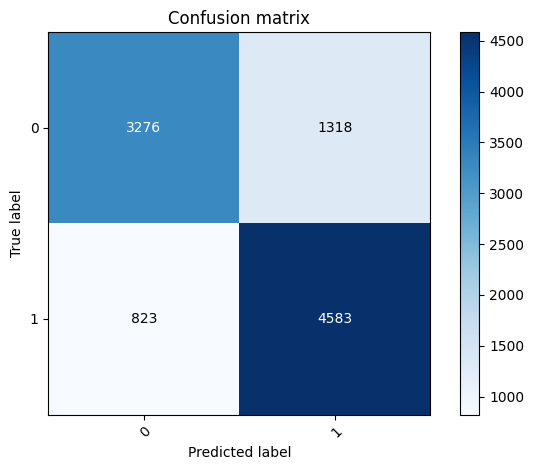

In [24]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_proc_df)

# Train the model
lr = LogisticRegression(
    max_iter = 10000
)
lr.fit(X_train_scaled, y_train_proc)

# Test the model
X_test_scaled = scaler.transform(X_test_proc_df)
y_pred = lr.predict(X_test_scaled)
print("Classification report of classifier: \n", classification_report(y_test_proc, y_pred))
print("ROC AUC score of classifier: ", roc_auc_score(y_test_proc, y_pred))

plot_confusion_matrix(y_test_proc, y_pred)


Logistic regression is very simple, the results are not great --> .78 accuracy and not close to .86 desired.

Classification report of classifier: 
               precision    recall  f1-score   support

           0       0.80      0.91      0.85      4594
           1       0.91      0.81      0.86      5406

    accuracy                           0.85     10000
   macro avg       0.86      0.86      0.85     10000
weighted avg       0.86      0.85      0.85     10000

ROC AUC score of classifier:  0.8577503253048783


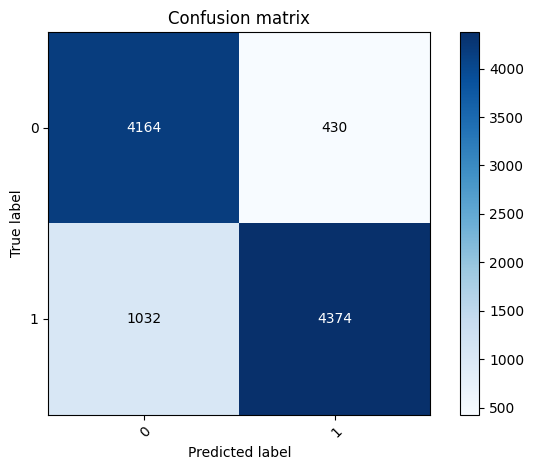

In [25]:
# Decision Trees (Scaled)
from sklearn.tree import DecisionTreeClassifier

# Scaling may not be necesary in this case but we will test
# both ways
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_proc_df)

# Train the model
dt = DecisionTreeClassifier(
    max_depth = 10,
    min_samples_leaf = 5
)
dt.fit(X_train_scaled, y_train_proc)

# Test the model
X_test_scaled = scaler.transform(X_test_proc_df)
y_pred = dt.predict(X_test_scaled)
print("Classification report of classifier: \n", classification_report(y_test_proc, y_pred))
print("ROC AUC score of classifier: ", roc_auc_score(y_test_proc, y_pred))

plot_confusion_matrix(y_test_proc, y_pred)


Classification report of classifier: 
               precision    recall  f1-score   support

           0       0.82      0.88      0.85      4594
           1       0.89      0.84      0.86      5406

    accuracy                           0.85     10000
   macro avg       0.85      0.86      0.85     10000
weighted avg       0.86      0.85      0.85     10000

ROC AUC score of classifier:  0.856174454897902


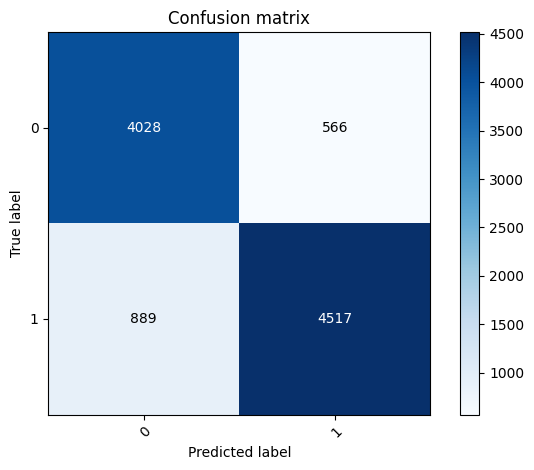

In [26]:
# Decision Trees (Unscaled)
from sklearn.tree import DecisionTreeClassifier

# Train the model
dt = DecisionTreeClassifier(
    max_depth = 10,
    min_samples_leaf = 5
)
dt.fit(X_train_proc_df, y_train_proc)

# Test the model
y_pred = dt.predict(X_test_proc_df)
print("Classification report of classifier: \n", classification_report(y_test_proc, y_pred))
print("ROC AUC score of classifier: ", roc_auc_score(y_test_proc, y_pred))

plot_confusion_matrix(y_test_proc, y_pred)


Scaling seems to have a minimal positive impact, still below .86 accuracy but very close.

Classification report of classifier: 
               precision    recall  f1-score   support

           0       0.84      0.85      0.85      4594
           1       0.87      0.86      0.87      5406

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

ROC AUC score of classifier:  0.8576731363642294


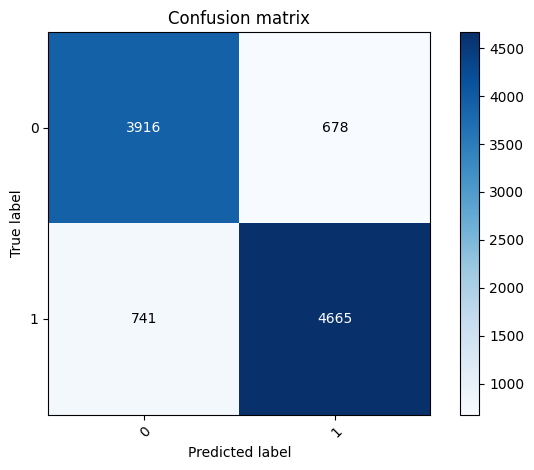

In [27]:
# Random Forest (Scaled)
from sklearn.ensemble import RandomForestClassifier

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_proc_df)

# Train the model
rf = RandomForestClassifier(
    n_estimators = 100,
    max_depth = 10,
    min_samples_leaf = 5
)
rf.fit(X_train_scaled, y_train_proc)

# Test the model
X_test_scaled = scaler.transform(X_test_proc_df)
y_pred = rf.predict(X_test_scaled)

print("Classification report of classifier: \n", classification_report(y_test_proc, y_pred))
print("ROC AUC score of classifier: ", roc_auc_score(y_test_proc, y_pred))

plot_confusion_matrix(y_test_proc, y_pred)


Decision trees perform better (very small differece)

Classification report of classifier: 
               precision    recall  f1-score   support

           0       0.78      0.73      0.75      4594
           1       0.78      0.83      0.80      5406

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.78      0.78      0.78     10000

ROC AUC score of classifier:  0.7773278646358043


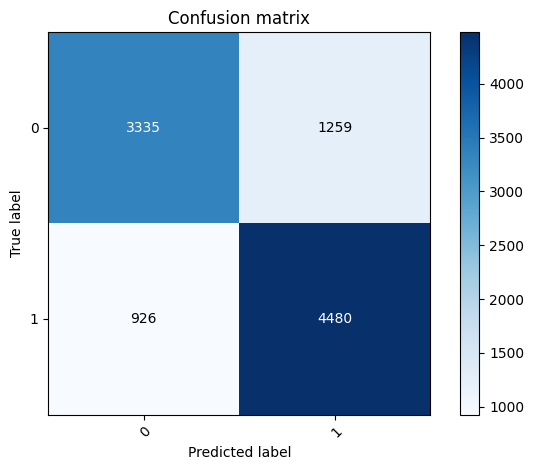

In [30]:
# SVM (Scaled)
from sklearn.svm import SVC

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_proc_df)

# Train the model
svm = SVC(
    C = 1,
    kernel = 'rbf',
    gamma = 'auto'
)
svm.fit(X_train_scaled, y_train_proc)

# Test the model
X_test_scaled = scaler.transform(X_test_proc_df)
y_pred = svm.predict(X_test_scaled)

print("Classification report of classifier: \n", classification_report(y_test_proc, y_pred))
print("ROC AUC score of classifier: ", roc_auc_score(y_test_proc, y_pred))

plot_confusion_matrix(y_test_proc, y_pred)


Classification report of classifier: 
               precision    recall  f1-score   support

           0       0.84      0.88      0.86      4594
           1       0.90      0.85      0.87      5406

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

ROC AUC score of classifier:  0.8682915079602455


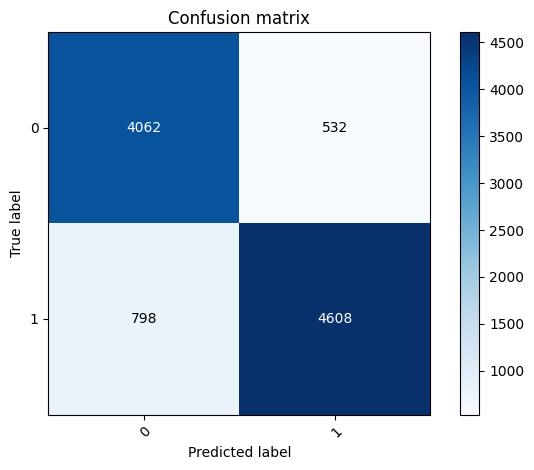

In [32]:
# XGBoost (Scaled)
from xgboost import XGBClassifier

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_proc_df)

# Train the model
xgb = XGBClassifier(
    n_estimators = 100,
    max_depth = 10,
)
xgb.fit(X_train_scaled, y_train_proc)

# Test the model
X_test_scaled = scaler.transform(X_test_proc_df)
y_pred = xgb.predict(X_test_scaled)

print("Classification report of classifier: \n", classification_report(y_test_proc, y_pred))
print("ROC AUC score of classifier: ", roc_auc_score(y_test_proc, y_pred))

plot_confusion_matrix(y_test_proc, y_pred)


We got a good accuracy above the requested .87. Let's test one more model (MLP) before improving the current one.

Classification report of classifier: 
               precision    recall  f1-score   support

           0       0.76      0.88      0.82      4594
           1       0.88      0.77      0.82      5406

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.83      0.82      0.82     10000

ROC AUC score of classifier:  0.8236834272566108


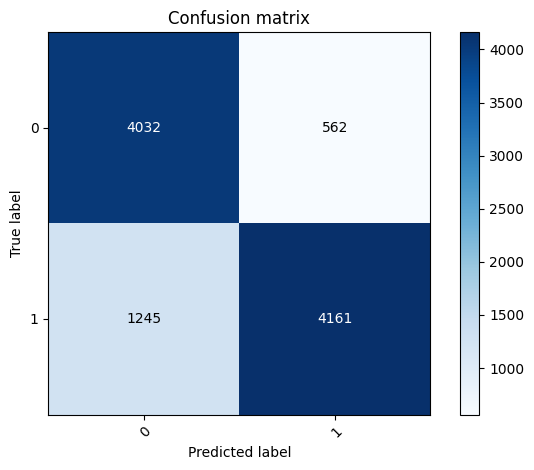

In [38]:
# MLP (Scaled)
from sklearn.neural_network import MLPClassifier

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_proc_df)

# Train the model
mlp = MLPClassifier(
    hidden_layer_sizes = (50, 50, 50),
    alpha = 0.001,
    learning_rate_init = 0.0001,
    max_iter = 500
)
mlp.fit(X_train_scaled, y_train_proc)

# Test the model
X_test_scaled = scaler.transform(X_test_proc_df)
y_pred = mlp.predict(X_test_scaled)

print("Classification report of classifier: \n", classification_report(y_test_proc, y_pred))
print("ROC AUC score of classifier: ", roc_auc_score(y_test_proc, y_pred))

plot_confusion_matrix(y_test_proc, y_pred)


# Performance metric
If I'm a buyer, I dont' want to buy something as "new" and then realize that what I bought is "used". So with this logic, we should prioritize avoiding false positives (predict an item as "new" when it's actually "used"), and the most relevant metric would be **Precision**.

Precision is the ratio of true positives to the total number of positive predictions. It quantifies the accuracy of positive predictions. High precision indicates a low rate of false positives. It's a good choice when you want to minimize the risk of incorrectly classifying negatives as positives, and in our case classifying an item that is "used" as "new".

Another metric that we could use is the F1 Score which is the harmonic mean of precision and recall. This is usefull when we want to reduce false positives without compromising too much on the ability to capture true positives.

In [49]:
from sklearn.model_selection import GridSearchCV

# Scaling may not be necesary in this case but we will test
# both ways
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_proc_df)

# Define the parameter grid to search
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 500, 1000],
    'gamma': [0, 0.1, 0.5],
    'subsample': [0.5, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
}

# Create an XGBClassifier object
xgb_clf = XGBClassifier()

# Create a GridSearchCV object
grid_search = GridSearchCV(
    estimator = xgb_clf,
    param_grid = param_grid,
    scoring = 'accuracy',
    cv = 5,
    n_jobs = -1,
    verbose = 1
)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train_scaled, y_train_proc)

# Print the best hyperparameters and the corresponding accuracy score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best accuracy score: ", grid_search.best_score_)


Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best hyperparameters:  {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500, 'reg_alpha': 0, 'reg_lambda': 0.1, 'subsample': 0.8}
Best accuracy score:  0.869511111111111


## Gridsearch Results
Because the code above takes a long time, the results of the Gridsearch is the following:
```
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best hyperparameters:  {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500, 'reg_alpha': 0, 'reg_lambda': 0.1, 'subsample': 0.8}
Best accuracy score:  0.869511111111111
```

### RFE
To testi if we can imporve the performance, we will use less features and try using Recursive feature elimination to reduce the complexity of the model and see if the accuracy can be improved.

In [63]:
# Improving via RFE
from sklearn.feature_selection import RFE

# Create a Random Forest Classifier object
rfc = RandomForestClassifier()

# Create an RFE object with 10 features to select
rfe = RFE(
    estimator = rfc, n_features_to_select = 30
)

# Fit the RFE object to the training data
rfe.fit(X_train_proc_df, y_train_proc)

# Print the selected features
print("Selected features: ", X_train_proc_df.columns[rfe.support_])


Selected features:  Index(['price', 'accepts_mercadopago', 'automatic_relist', 'initial_quantity',
       'sold_quantity', 'available_quantity', 'shipping.local_pick_up',
       'shipping.free_shipping', 'non_mercado_pago_payment_methods_count',
       'pictures_count', 'age_days', 'duration_days', 'listing_type_id_bronze',
       'listing_type_id_free', 'listing_type_id_gold',
       'listing_type_id_gold_special', 'listing_type_id_silver',
       'buying_mode_buy_it_now', 'buying_mode_classified', 'status_active',
       'status_paused', 'shipping.mode_custom', 'shipping.mode_me2',
       'shipping.mode_not_specified', 'dragged_bids_and_visits', 'MLATB',
       'MLAWC', 'MLAMO', 'MLAOT', 'MLAWT'],
      dtype='object')


Classification report of classifier: 
               precision    recall  f1-score   support

           0       0.84      0.88      0.86      4594
           1       0.90      0.86      0.88      5406

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

ROC AUC score of classifier:  0.8705112637871045


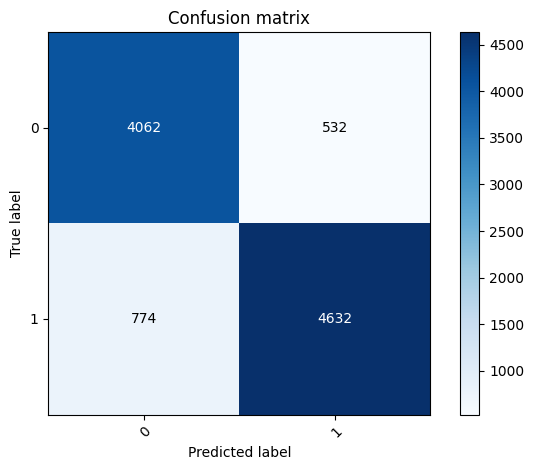

In [64]:
selected_features = X_train_proc_df.columns[rfe.support_]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_proc_df[selected_features])

# Train the model
xgb = XGBClassifier(
    **grid_search.best_params_
)
xgb.fit(X_train_scaled, y_train_proc)

# Test the model
X_test_scaled = scaler.transform(X_test_proc_df[selected_features])
y_pred = xgb.predict(X_test_scaled)

print("Classification report of classifier: \n", classification_report(y_test_proc, y_pred))
print("ROC AUC score of classifier: ", roc_auc_score(y_test_proc, y_pred))

plot_confusion_matrix(y_test_proc, y_pred)


# Conclusion

Using 25 features from the RFE selection and using the best parameters from the gridsearch we are able to obtain higher accuracy and higher precision too, which is our second metric of choose.

So in conclusion:
- Our algorithm is XGBoost
- Our first metric is accuracy, the result is 0.87
- Our second metric is Precision, the result is 0.90 for "new" items and 0.87 average.
- The hyperparams for XGBoost were chosen via GridSearchCV: `{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500, 'reg_alpha': 0, 'reg_lambda': 0.1, 'subsample': 0.8}`
- The features selected to reduce complexity and improve performance was done via RFE and the list is as follow (from 49 to 30): `'price', 'accepts_mercadopago', 'automatic_relist', 'initial_quantity', 'sold_quantity', 'available_quantity', 'shipping.local_pick_up', 'shipping.free_shipping', 'non_mercado_pago_payment_methods_count', 'pictures_count', 'age_days', 'duration_days', 'listing_type_id_bronze', 'listing_type_id_free', 'listing_type_id_gold', 'listing_type_id_gold_special', 'listing_type_id_silver', 'buying_mode_buy_it_now', 'buying_mode_classified', 'status_active', 'status_paused', 'shipping.mode_custom', 'shipping.mode_me2', 'shipping.mode_not_specified', 'dragged_bids_and_visits', 'MLATB', 'MLAWC', 'MLAMO', 'MLAOT', 'MLAWT'`

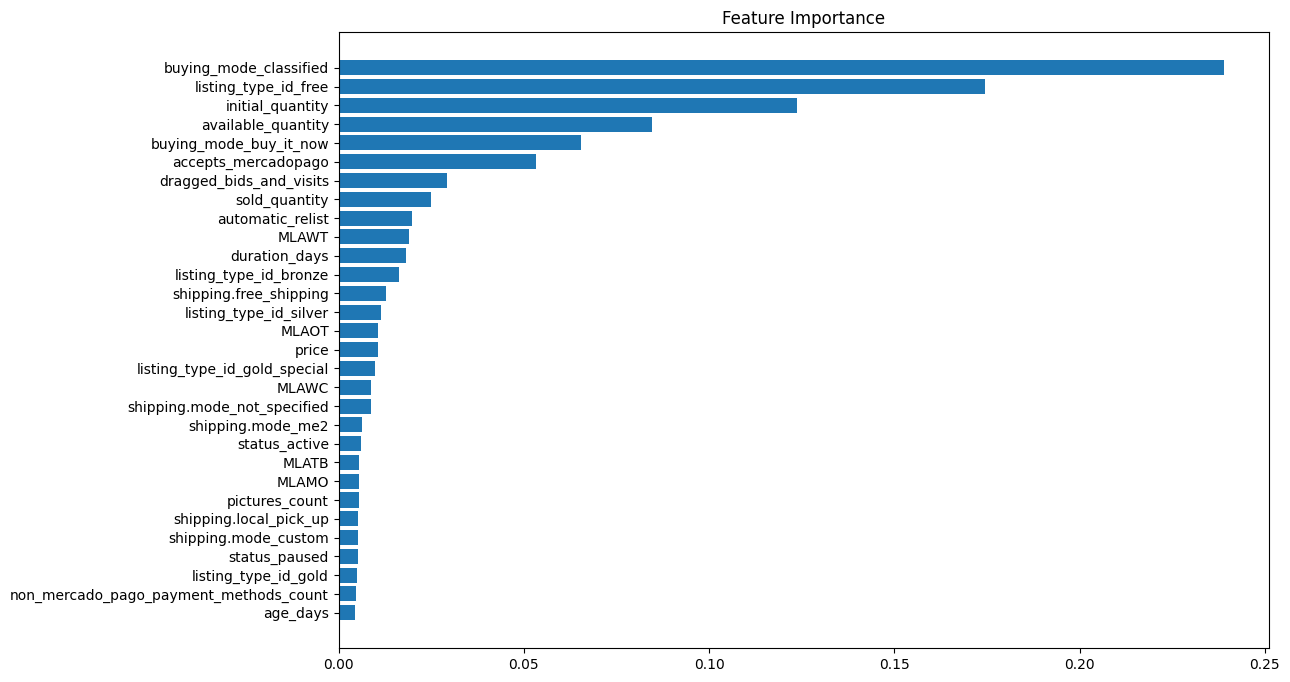

In [72]:
# Plot feature importance
feature_importance = xgb.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize = (12, 8))
plt.barh(
    range(len(sorted_idx)), feature_importance[sorted_idx], align = 'center'
)
plt.yticks(range(len(sorted_idx)), np.array(X_train_proc_df[selected_features].columns)[sorted_idx])
plt.title('Feature Importance')
plt.show()


This chart is good to understand the feature importance given by the model, we can see that there are some important pieces here that make sense for us and were also discussed during the EDA, for example the listing_type_id_free is a good indicator if the item is used or new, the buying_mode_classified also, the initial quantity and the available quantity as well.